# Exploración de Dataset: Balance Energético

## Importación de librerías y seteo de variables

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import openpyxl as pyxl
from __future__ import print_function
from __future__ import unicode_literals
# matplotlib defaults
%matplotlib inline
matplotlib.style.use("ggplot")
import os

In [3]:
FICHEROS = {"microdatos": "datos/Datos Abiertos Series V2a Original.xlsx",
            "sintesis": "datos/Resumen de los Datos.xlsx",
            "poblacion": "datos/serie_poblacion.csv"}

## Carga de datos

### Serie de población

In [4]:
df_pobl = pd.read_csv(FICHEROS["poblacion"],index_col="anio")
poblacion = pd.Series(data=df_pobl["poblacion"], index=df_pobl.index)

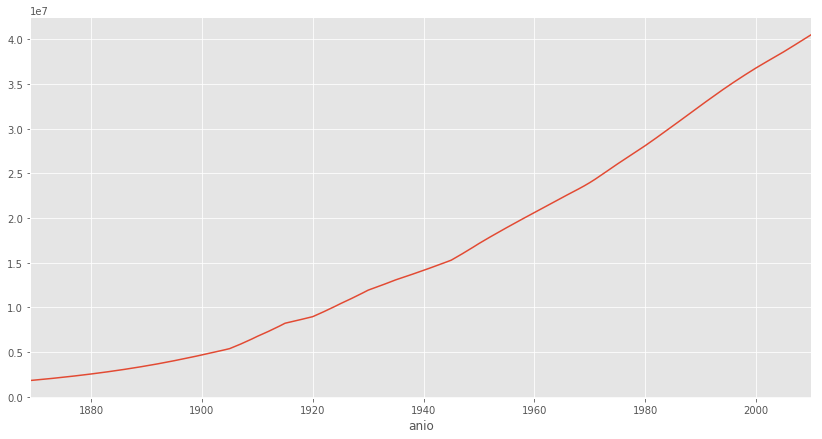

In [5]:
poblacion.plot(figsize=(14, 7))

### Parseo de microdatos de energía

A partir de la planilla de microdatos de Balance Energético, se genera un Panel de datos con los siguientes ejes:
* Items axis (**0**, DataFrames por año): 1960 to 2015
* Major_axis axis (**1**, Índice por Energía): ACEITES VEGETALES to SOLAR
* Minor_axis axis (**2**, Columnas por Uso): PROD to INDUS

In [6]:
wb = pyxl.load_workbook(FICHEROS["microdatos"], data_only=True)

In [7]:
def sheet_to_df(ws):
    raw_data = ws.values
    # La celda A1 tiene el nombre de la energía de la planilla
    name = next(raw_data)[0]
    cols = next(raw_data)
    rows = list(raw_data)[:56] # Luego de 56 filas de años, algunas sheets tienen aclaraciones
    df = pd.DataFrame.from_records(rows, columns=cols)
    # Asigno índice y corrijo el nombre
    df = df.set_index("KTEP")
    df.index = df.index.rename("anio")
    # Elimino las columnas vacías
    df = df.drop(None, axis=1)
    # Relleno None y NaN con ceros
    df = df.fillna(0)
    return df, name

In [8]:
ENERGIAS = {}
for ws in wb.worksheets:
    df, energia = sheet_to_df(ws)
    ENERGIAS[energia] = df

In [9]:
pan_crudo = pd.Panel(ENERGIAS)
pan_crudo = pan_crudo.transpose(1, 0, 2)
pan_crudo

<class 'pandas.core.panel.Panel'>
Dimensions: 56 (items) x 31 (major_axis) x 23 (minor_axis)
Items axis: 1960 to 2015
Major_axis axis: ACEITES VEGETALES to SOLAR
Minor_axis axis: PROD to INDUS

### Cálculo del consumo final por año y energía

In [19]:
pan_crudo.loc[:,:,"CONSUMO TOTAL"] = reduce(
    pd.DataFrame.add, [pan_crudo[:,:,uso] for uso in ['NO ENER', 'RESID', 'COMER', 'TRANS', 'AGROP', 'INDUS']])

In [23]:
pan_crudo.loc[:, "TODAS LAS ENERGIAS", :] = reduce(
    pd.DataFrame.add, [pan_crudo[:, energia, :] for energia in pan_crudo.major_axis])

In [25]:
consumo_total = pan_crudo[:,"TODAS LAS ENERGIAS", "CONSUMO TOTAL"]

In [29]:
consumo_per_capita = consumo_total / poblacion.dropna()

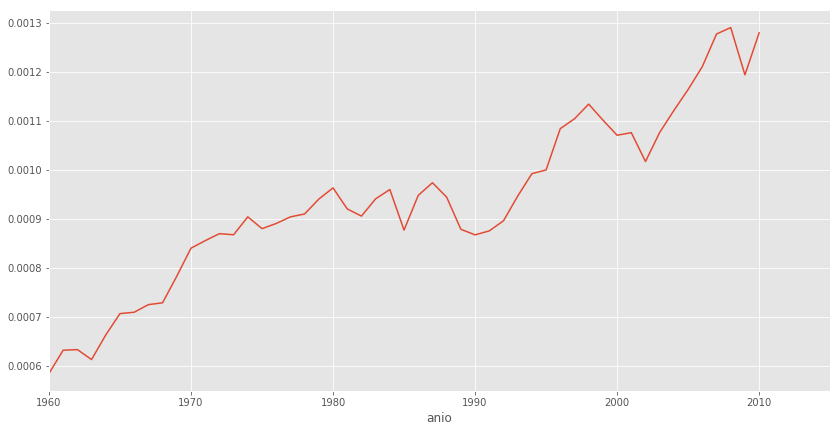

In [32]:
consumo_per_capita.plot(xlim=(1960,2015), figsize=(14,7))